# AIPI 590 - XAI | Assignment #3
### Explainable Techniques II
### Kayla Haeussler


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns, matplotlib.pyplot as plt

# For XAI techniques
import shap

# from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

I searched for a dataset on Kaggle, this dataset about wine caught my eye
https://www.kaggle.com/code/gamzegedik044/wine-type-classification-quality-prediction 

In [3]:
df = pd.read_csv("wine_quality_merged.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Exploring the data a bit

In [4]:
df["type"].value_counts()

type
white    4898
red      1599
Name: count, dtype: int64

In [5]:
df.groupby("type").agg(["mean", "std"])

fixed acidity           volatile acidity           citric acid  \
               mean       std             mean       std        mean   
type                                                                   
red        8.319637  1.741096         0.527821  0.179060    0.270976   
white      6.854788  0.843868         0.278241  0.100795    0.334192   

                residual sugar           chlorides            ...   density  \
            std           mean       std      mean       std  ...      mean   
type                                                          ...             
red    0.194801       2.538806  1.409928  0.087467  0.047065  ...  0.996747   
white  0.121020       6.391415  5.072058  0.045772  0.021848  ...  0.994027   

                       pH           sulphates              alcohol            \
            std      mean       std      mean       std       mean       std   
type                                                                           
red    0.001887  3.311113  0.154386  0.658149  0.169507  10.422983  1.065668   
white  0.002991  3.188267  0.151001  0.489847  0.114126  10.514267  1.230621   

        quality            
           mean       std  
type                       
red    5.636023  0.807569  
white  5.877909  0.885639  

[2 rows x 24 columns]

I want to use a random forest model here because they are my favorite. It has been a while since I have created one of these models, so I am using the following Data Camp tutorial as a reference
https://www.datacamp.com/tutorial/random-forests-classifier-python

Prepping data for model creating

In [9]:
y = df["type"]
X = df.drop("type", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Creating Random Forest Model

In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RF Model Accuracy: ", acc)

RF Model Accuracy:  0.9930769230769231


## Exploratory Analsysis  
To determine the amount of correlation between features

In [38]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

In [32]:
X.columns.values

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

#### Checking correlation between features and the target variable (wine type)

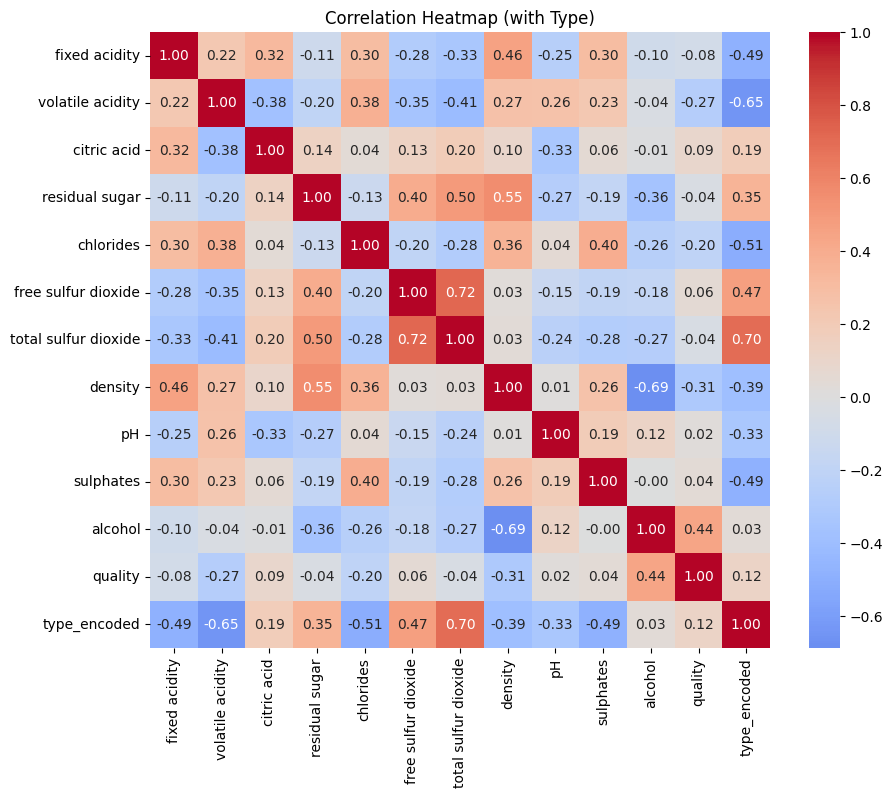

In [63]:
# The below code was generated using ChatGPT 5 on 9/28/25 at 7:18pm
# My prompt relayed that I wanted to make a correlation heatmap of all of my features
# and my categorical outcome, I adapted slightly for visual appearance


# Encode 'type' as numeric
df["type_encoded"] = df["type"].map({"red": 0, "white": 1})

corr = df.drop(columns=["type"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (with Type)")
plt.show()

Looking at the correlation heatmap, nothing is extremely concerning, but there are a couple of relationships worth noting. As far as high correlations between features, total sulfur dioxide and free sulfur dioxide have a correlation of 0.72, alcohol and residual sugars have a correlation of 0.55, and alcohol and density have a correlation of -0.69. I am not super familiar with wine, but reading the data card on Kaggle as well as some Googling of total and free sulfur dioxide in wines, shows that total dioxide is the sum of free and bound sulfur dioxide, and while total and free dioxide rise together, two wines with the same total dioxide can have very different free dioxide, which explains both the high correlation and the decision of the Kaggle dataset creators to include both columns in the first place. As far as alcohol and density and alcohol and residual sugars, these relationsips are not surprising to me as higher alcohol drinks would have lower density and drinks with a lot of sugar would ahve higher density.  
As far as relationships between the features and our dependent variable 'type', notable correlations included fixed acidity (-0.49), volatile acidity (-0.65), chlorides (-0.51), free sulfur dioxixde (0.47)

Sulfur Dioxide research source: https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/ 

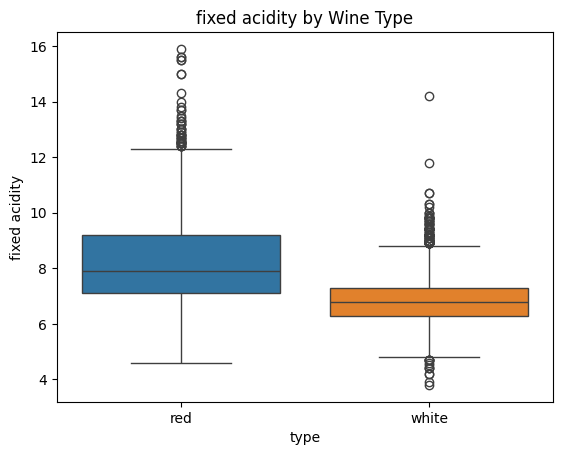

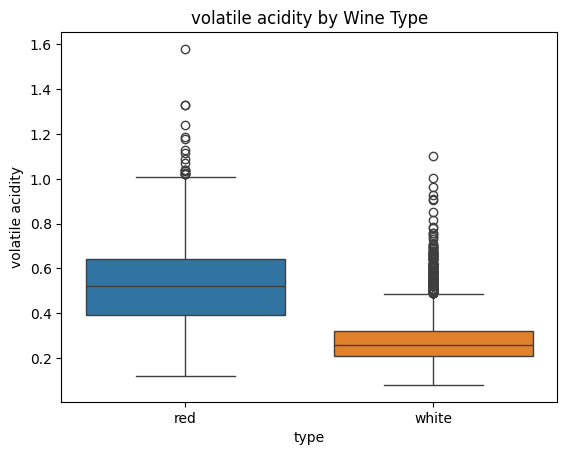

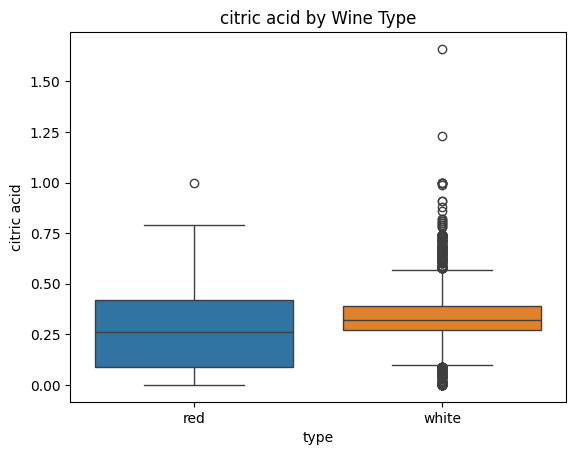

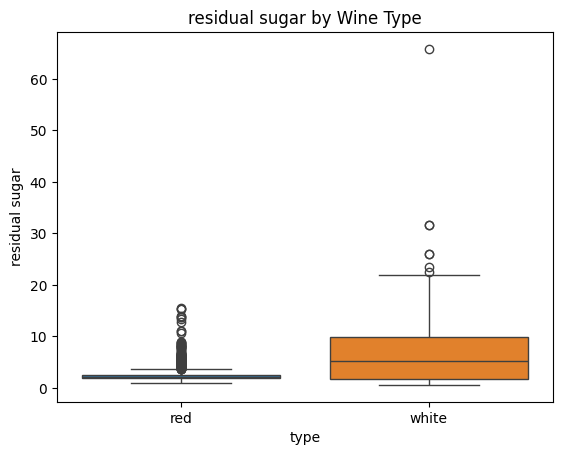

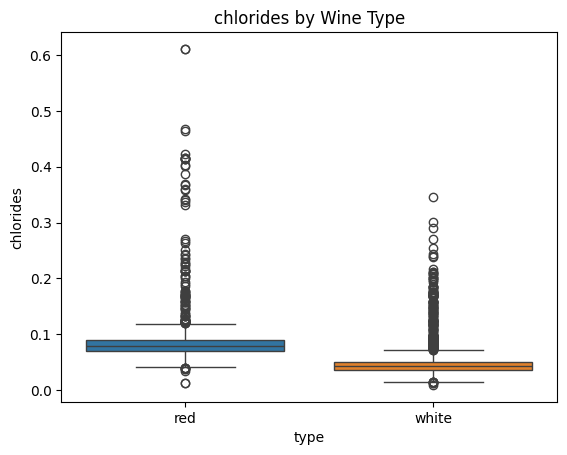

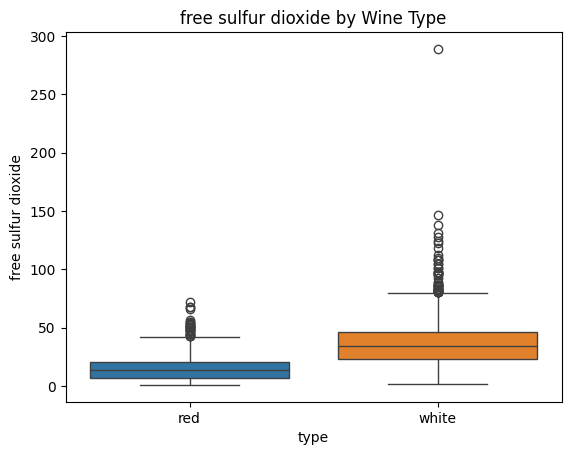

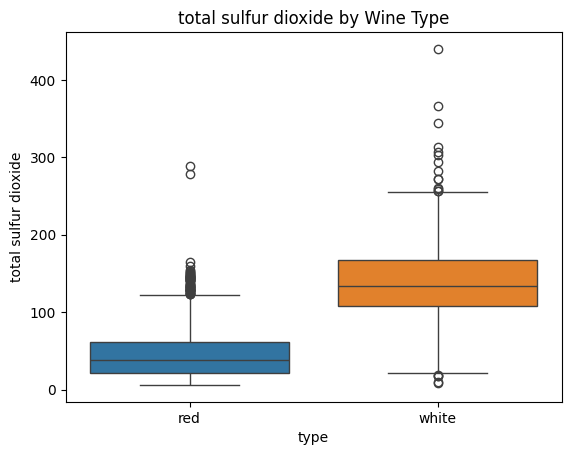

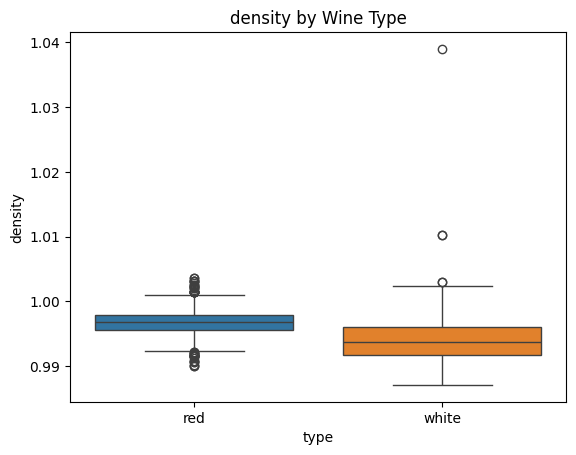

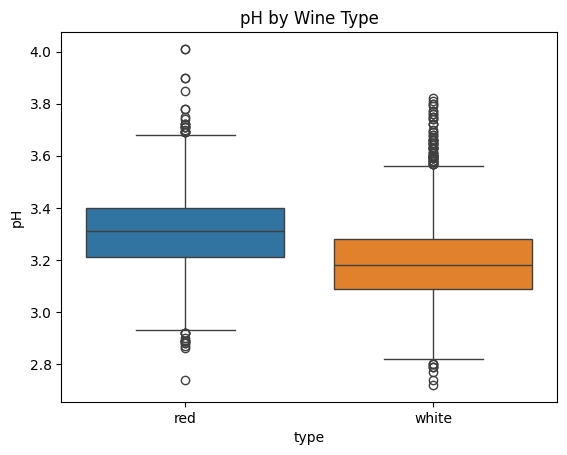

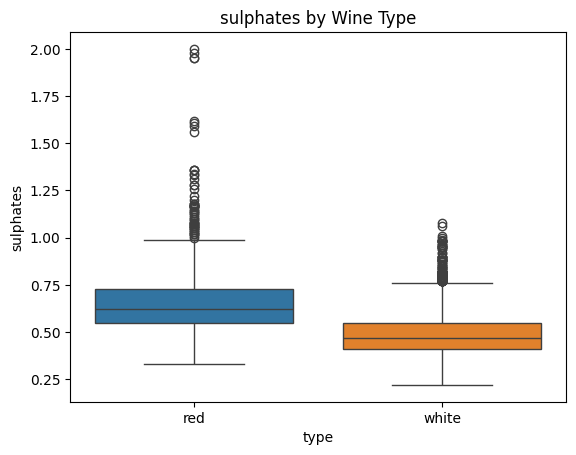

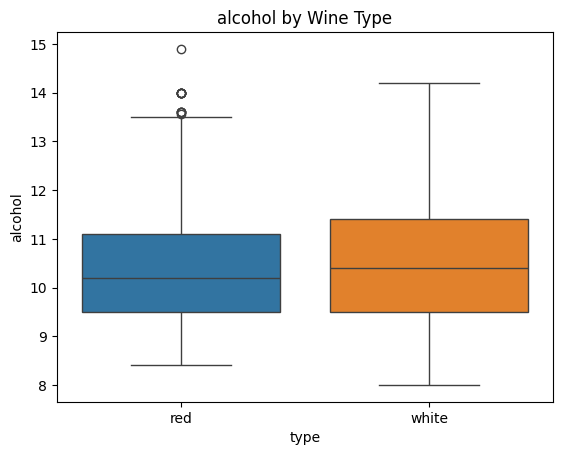

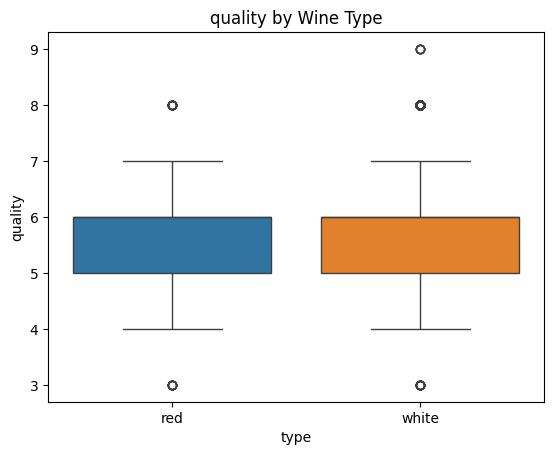

In [56]:
features = X.columns.values
for f in features:
    plt.figure()
    sns.boxplot(x="type", y=f, data=df, hue="type")
    # consulted seaborn documentation for boxplots
    # https://seaborn.pydata.org/generated/seaborn.boxplot.html
    plt.title(f"{f} by Wine Type")
    plt.show()

## PDP Plots

The following comes from Dr. Bent's global_explanations.ipynb, including the info here as it helps explain PDP

A Partial Dependence Plot (PDP or PD) shows the marginal effect one or two features have on the predicted outcome of a model  

How it Works:  
1. Select feature of interest  
2. For every instance in training dataset:  
    Keep all other features the same, create variants of the instance by replacing the feature’s value with values from a grid  
    Make predictions with the black box model for newly created instances  
    You now have a set of points for an instance with the feature value from the grid and the respective predictions  
3. Average across all instances and plot  

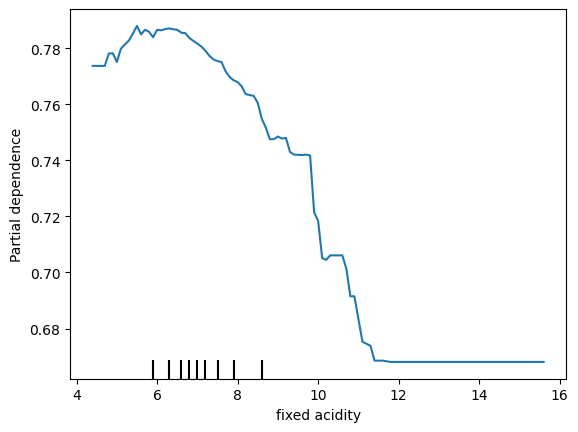

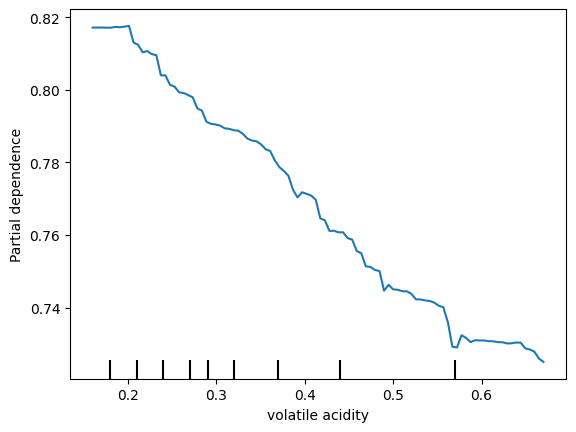

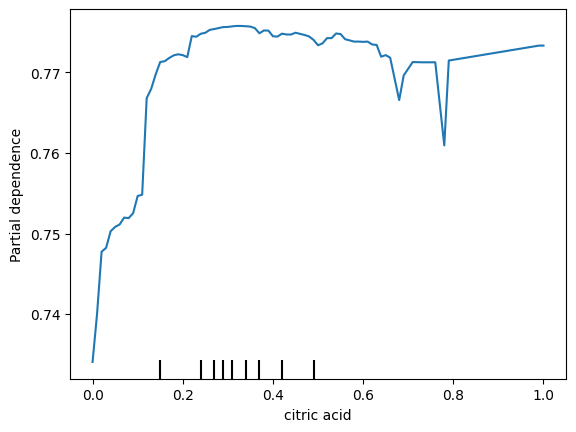

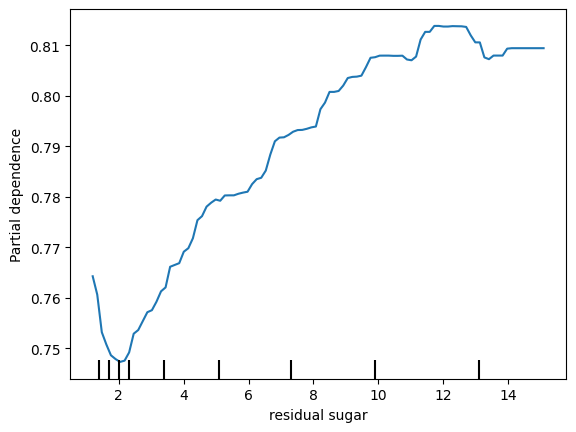

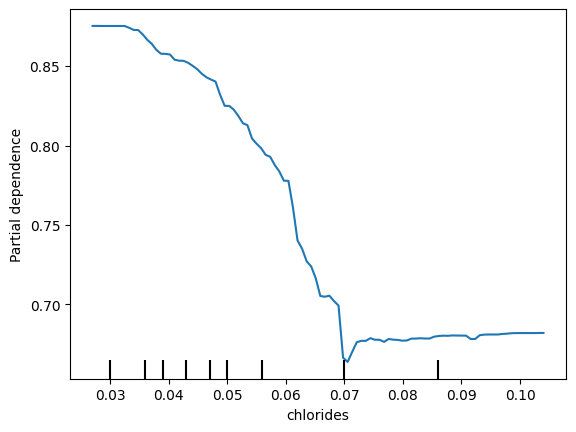

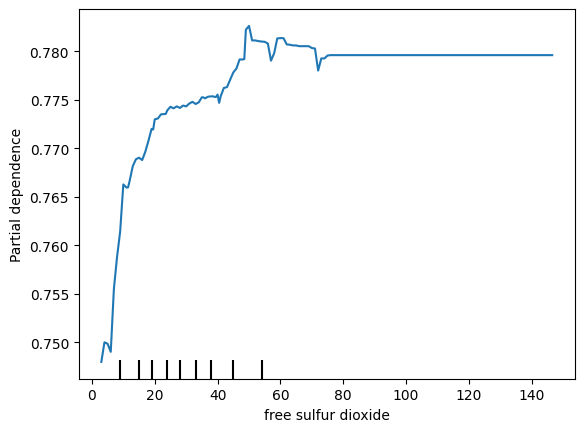

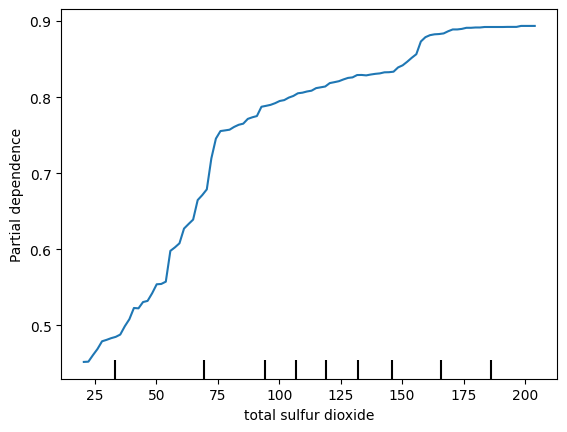

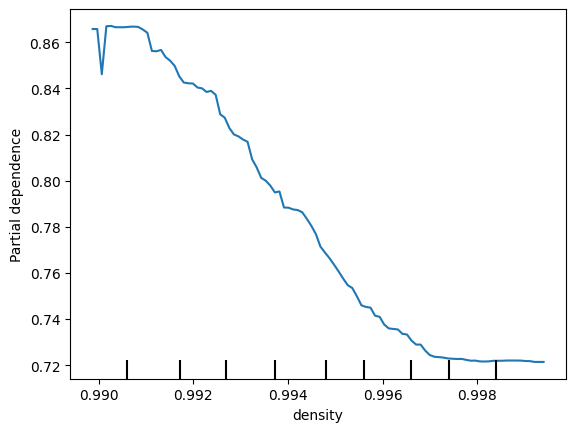

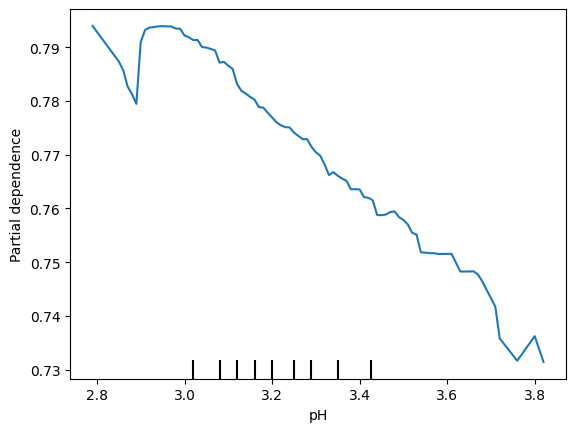

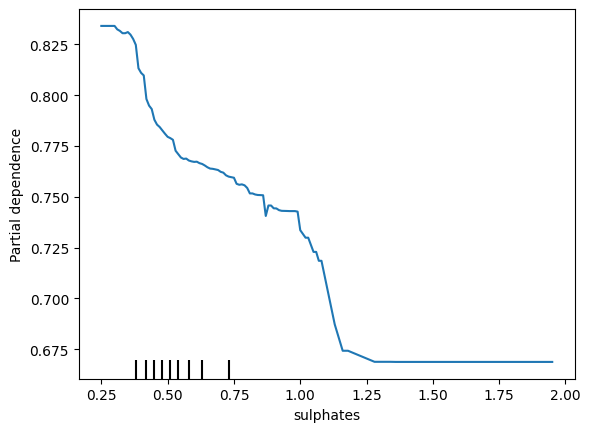

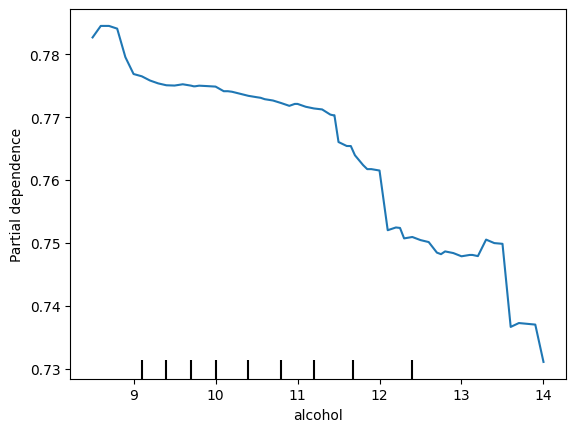

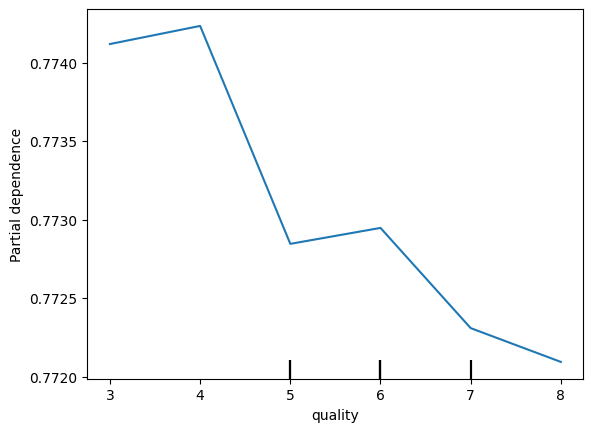

In [35]:
# code from Dr. Bent's global_explanations.ipynb
# adapting it slightly to loop and show plots for all of my features, since I dont have that many features

# Use PartialDependenceDisplay to plot PDP
for f in features:
    PartialDependenceDisplay.from_estimator(
        rf_model, X_test, [f], kind="average"
    )  # kind='both'

# Chat GPT-5 wwas used 2:37pm on 9/25 because after I adapted the code from Dr.Bent's notebook to loop across features
# I was getting an error just referencing f in my PartialDependenceDisplay call,
# so I fed the error to GPT5 and it pointed out that i need to add brackets around f since the function was interpreting it as me passing it the string 'f'

## ICE Plots

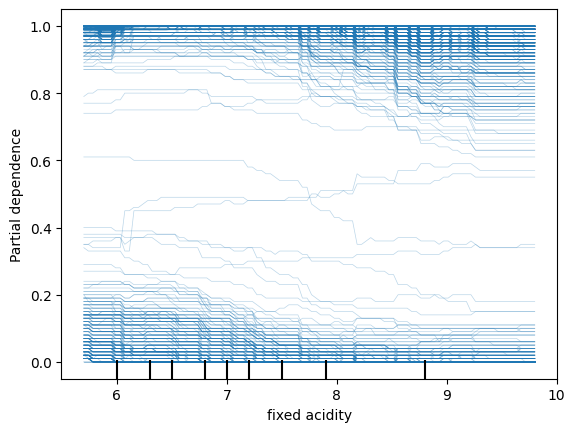

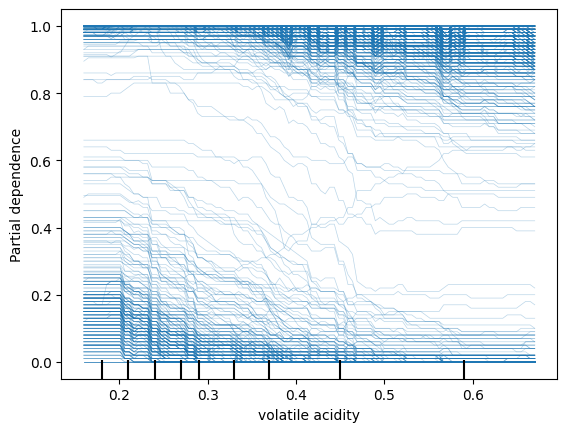

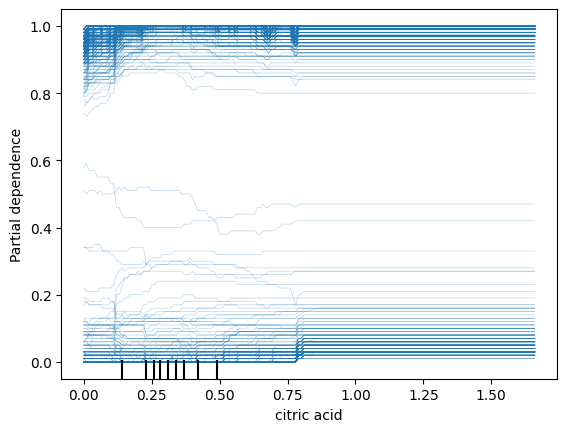

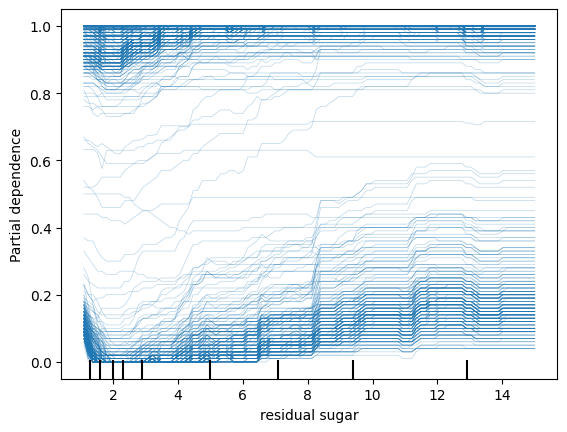

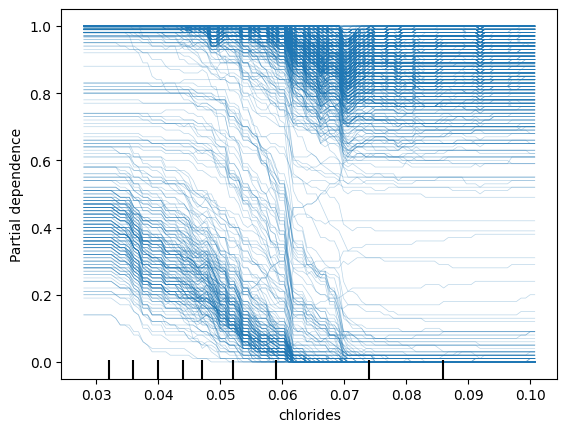

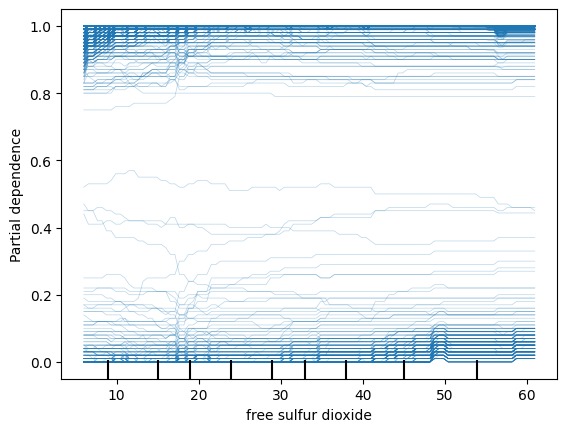

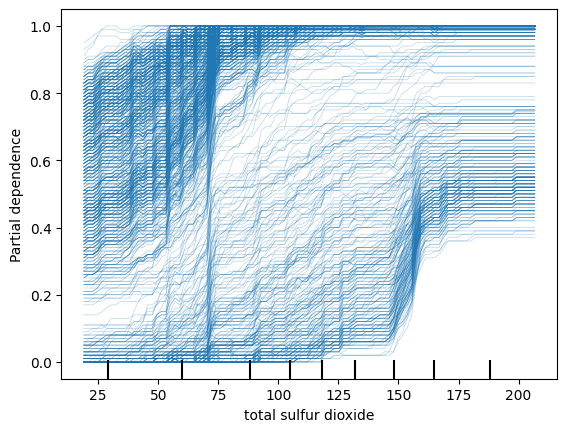

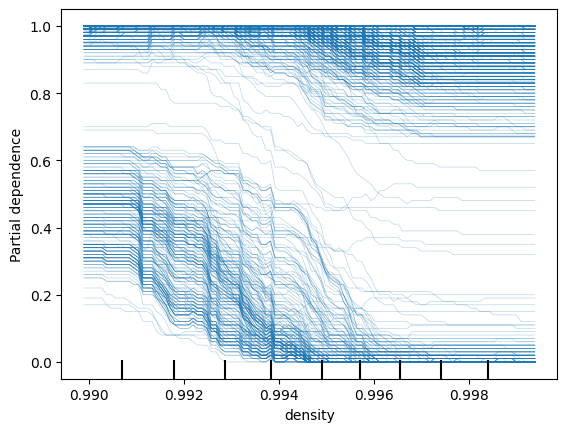

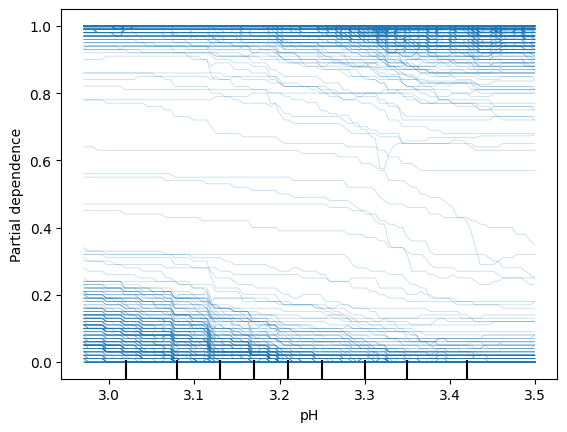

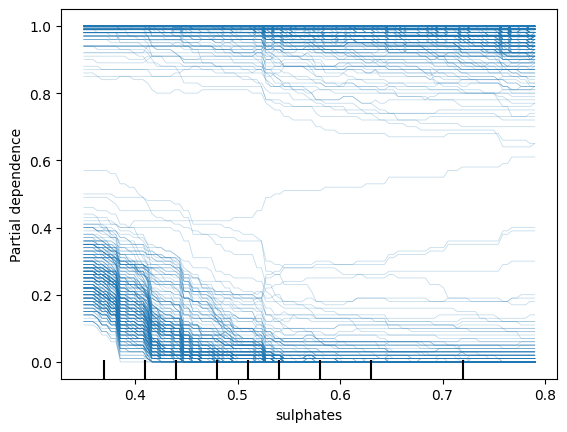

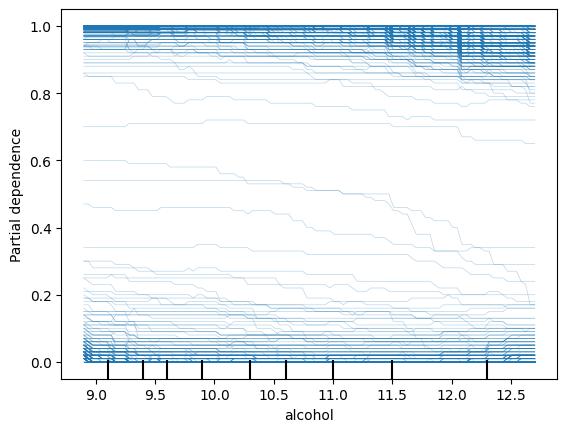

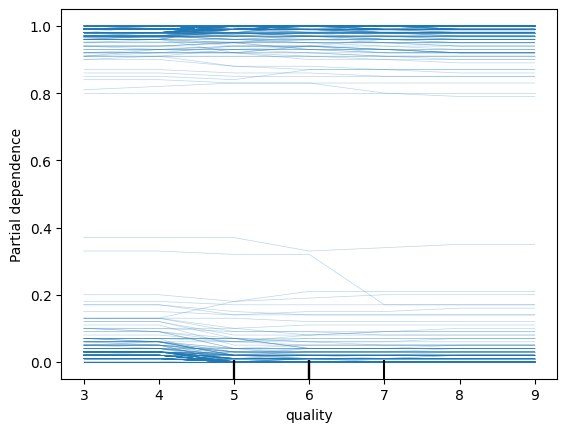

In [37]:
for f in features:
    PartialDependenceDisplay.from_estimator(rf_model, X_train, [f], kind="individual")

## ALE Plots

In [48]:
pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /private/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/pip-install-8bqvfoqc/alepython_c559083a2bb542c5b7983a22fd284fca
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /private/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/pip-install-8bqvfoqc/alepython_c559083a2bb542c5b7983a22fd284fca
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15273 sha256=ad86e9a855170ce5d82b79b1a7cf3c309e4dfc5c239bd9474cb11db9dba9b7d4
  Stored in directory: /private/var/folders/bs/tlrmg2n164520pry59rs7fvh0000gn/T/pip-ephem-wheel-cache-qgtft8ke/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython
Note: you may need to restart the kernel to use upda

In [50]:
for f in features:
    alepython(rf_model, X_train, [f], monte_carlo=True)

NameError: name 'alepython' is not defined